# Introduction

The study aims to predict the price of flight booking given the features. Estimating flight booking price can be useful to both airlines and the customers. The model can help airline to set a fair-price to the new flights, while the customers can be able to get the lowest price based on their comfort level. The flight booking price are dependent on various features like the demand on the day, airline, number of stops, duration of travel, number of days before travel, class, etc. The given dataset has most of the relevant features as mentioned above. We will explore the dataset to analyse and indetify the trends and patterns of price based on the predictors and build regression model that can predict the flight booking price.

# Exploratory data analysis

## Initial data cleaning

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.api import OLS, add_constant
import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/Flight_Booking.csv', index_col=0)
df.sample(5)

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
139729,Indigo,6E-893,Kolkata,Morning,one,Evening,Bangalore,Economy,10.50,31,5744
91809,Air_India,AI-503,Bangalore,Evening,zero,Night,Delhi,Economy,2.75,39,4071
24533,GO_FIRST,G8-7533,Delhi,Afternoon,one,Night,Kolkata,Economy,10.08,26,5954
105077,Vistara,UK-657,Bangalore,Morning,two_or_more,Evening,Kolkata,Economy,8.08,18,17989
69147,Vistara,UK-944,Mumbai,Afternoon,one,Night,Kolkata,Economy,8.08,43,5949


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300153 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  object 
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  object 
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 27.5+ MB


The dataset consist of `300153` with `9` predictors. `7` of them are objects and `2` are numerical. The response variable `price` is also numerical. Let's analyse the number of unique values in each feature to identify the categorical/discrete and numerical predictors.

## Categorical and numerical variables

In [4]:
nuniques = df.apply(lambda x: x.nunique())
nuniques

airline                 6
flight               1561
source_city             6
departure_time          6
stops                   3
arrival_time            6
destination_city        6
class                   2
duration              476
days_left              49
price               12157
dtype: int64

From the number of unique values, we can see only categorical column with more unique values is the `flight` column, which would tend to create a wide dataframe on one-hot encoding. Ordinal encoding is also not appropriate for the feature. In further steps, we will understand how the `flight` column correlates with other columns. If there is multi-collinearity, we will drop the feature. Else, we will keep top-n based on frequency and bin the rest as `other`. 

Now let's seperate the column names into separate lists as `categorical`, `numerical`, `target`, `others`.

In [5]:
numerical = df.select_dtypes(np.number).columns[:-1].to_list()
categorical = df.select_dtypes('object').columns.drop('flight').to_list()
others = ['flight']
target = 'price'

print(f'numerical variables: {numerical}\n\ncategorical variables: {categorical}\n\nothers: {others}\n\ntarget: {target}')

numerical variables: ['duration', 'days_left']

categorical variables: ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time', 'destination_city', 'class']

others: ['flight']

target: price


## Unique values in categorical features

In [6]:
uniques = df[categorical].apply(lambda x: list(x.unique())).to_dict()
for x in uniques:
    print(f'{x}: {uniques[x]}', end='\n\n')

airline: ['SpiceJet', 'AirAsia', 'Vistara', 'GO_FIRST', 'Indigo', 'Air_India']

source_city: ['Delhi', 'Mumbai', 'Bangalore', 'Kolkata', 'Hyderabad', 'Chennai']

departure_time: ['Evening', 'Early_Morning', 'Morning', 'Afternoon', 'Night', 'Late_Night']

stops: ['zero', 'one', 'two_or_more']

arrival_time: ['Night', 'Morning', 'Early_Morning', 'Afternoon', 'Evening', 'Late_Night']

destination_city: ['Mumbai', 'Bangalore', 'Kolkata', 'Hyderabad', 'Chennai', 'Delhi']

class: ['Economy', 'Business']



Based on the unique values, we can see that the features `stop` and `class` are ordinal in nature where we use ordinal encoding, while the other features are nominal and we will use one-hot encoding.

## Summary of categorical features

In [7]:
df[categorical].describe().T

,count,unique,top,freq
airline,300153,6,Vistara,127859
source_city,300153,6,Delhi,61343
departure_time,300153,6,Morning,71146
stops,300153,3,one,250863
arrival_time,300153,6,Night,91538
destination_city,300153,6,Mumbai,59097
class,300153,2,Economy,206666


The description table above shows the number of most common occurance for each feature and its frequency. We will analyse their distributions better during the visualization phase.

## Summary of numerical features

In [8]:
df[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
duration,300153.0,12.221021,7.191997,0.83,6.83,11.25,16.17,49.83
days_left,300153.0,26.004751,13.561004,1.00,15.00,26.00,38.00,49.00


From the description table, it is clear that the mean adn median are close to each other. The gap between the quantiles are fairly even for the days_left, while for the duration, the 100th quantile is skewed, suggesting the presence of outliers. We will detect and process them in the visualization phase.

# Visualization

## Univariate analysis

### Count plots of categorical features

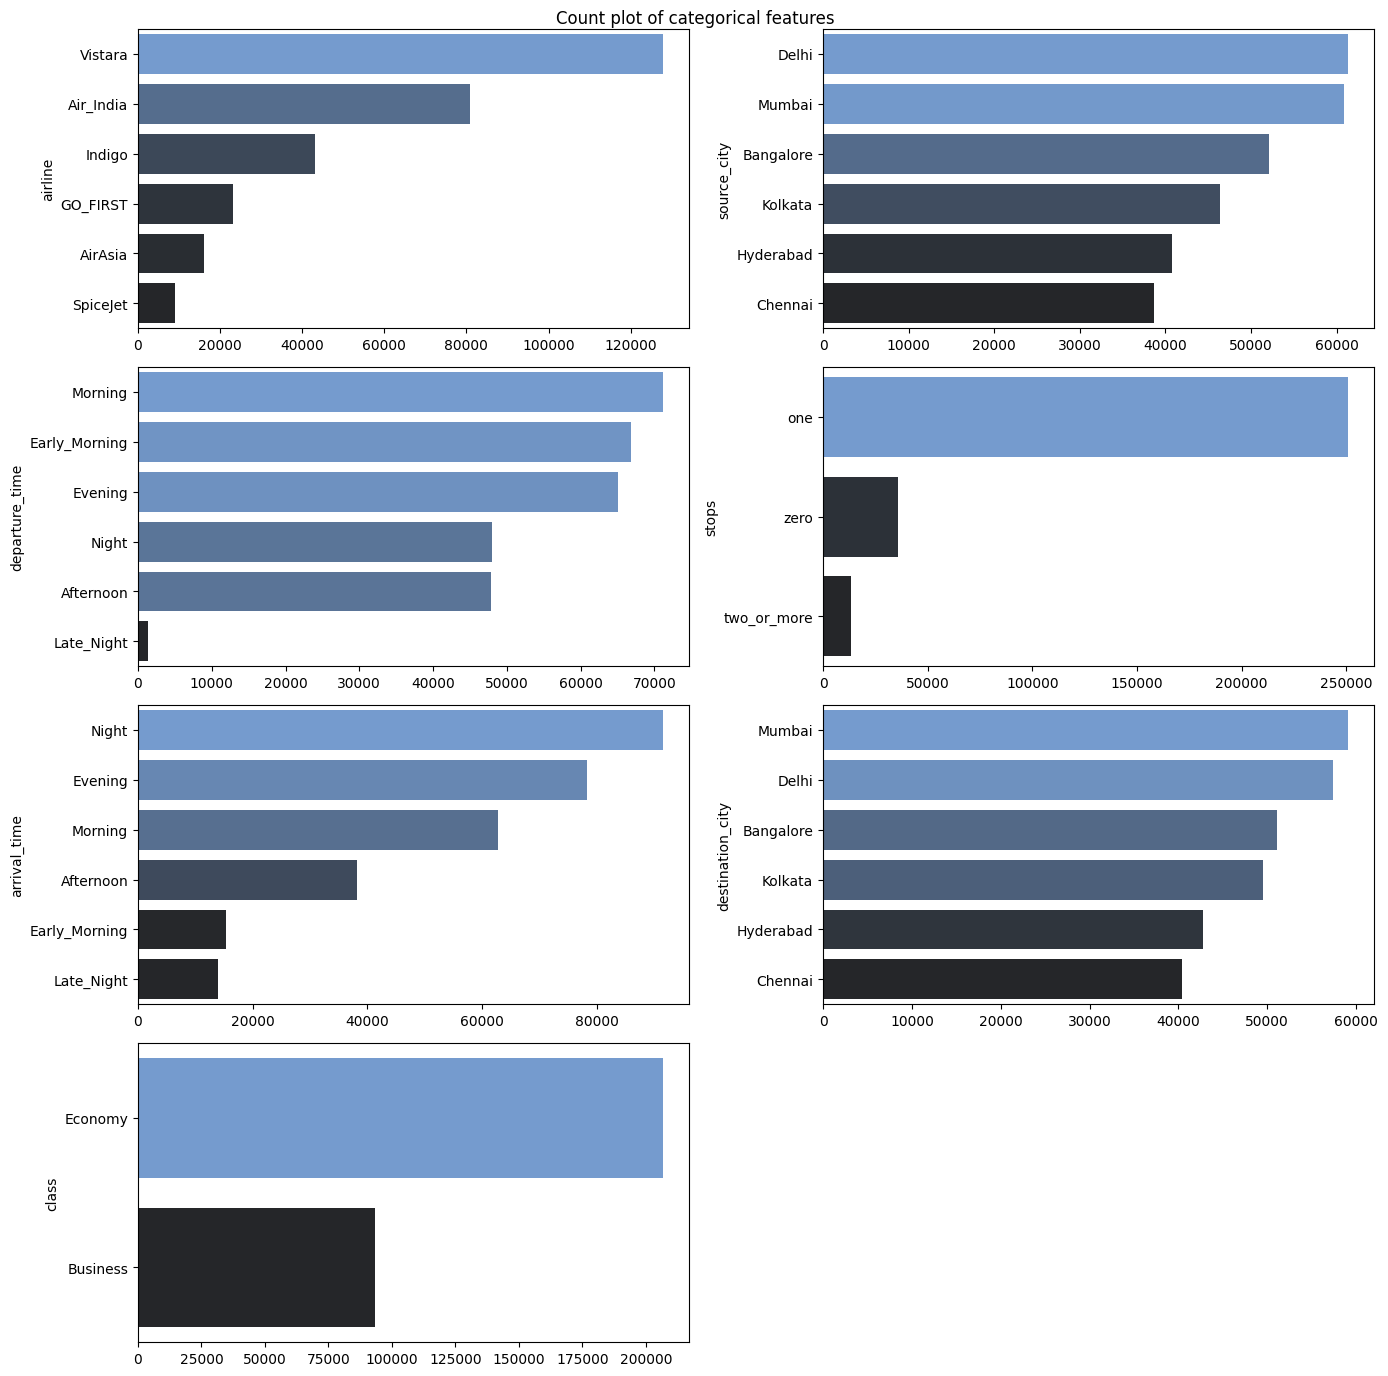

In [9]:
fig, ax = plt.subplots(nrows=len(categorical)//2 + 1, ncols=2, figsize=(14, len(categorical)*2))

for i, col in enumerate(categorical):
    ind = divmod(i, 2)
    counts = df[col].value_counts()
    counts = (counts - counts.min()) / (counts.max() - counts.min())
    order = counts.index
    palette = sns.dark_palette('#69d', as_cmap=True)
    mapping = {value: palette(norm_count) for value, norm_count in zip(order, counts)}
    sns.countplot(df, y=col, ax=ax[ind], order=df[col].value_counts().index, palette=mapping)
    ax[ind].set_xlabel('')

fig.delaxes(ax[len(categorical)//2, 1])
if len(categorical)%2 == 0:
    fig.delaxes(ax[len(categorical)//2, 0])

    

fig.suptitle('Count plot of categorical features')
plt.tight_layout()

The count plot shows the discrete distribution of all the categorical features. 

### Histograms of numerical features

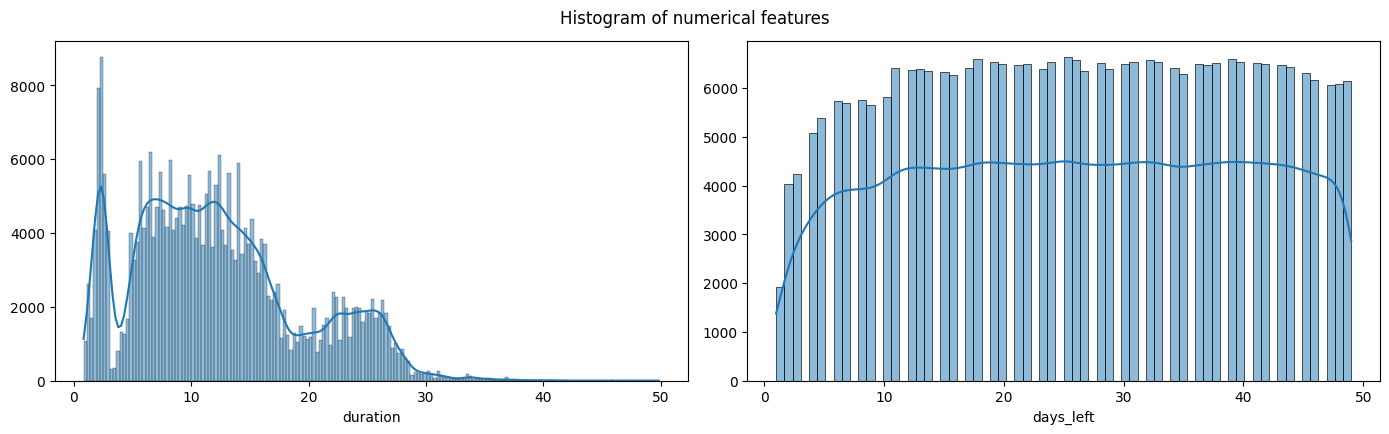

In [10]:
fig, ax = plt.subplots(nrows=len(numerical)//2+1, ncols=2, figsize=(14, len(numerical)*4))

for i, col in enumerate(numerical):
    ind = divmod(i, 2)
    sns.histplot(df, x=col, ax=ax[ind], kde=True)
    ax[ind].set_ylabel('')

fig.delaxes(ax[len(numerical)//2, 1])
if len(numerical)%2 == 0:
    fig.delaxes(ax[len(numerical)//2, 0])

fig.suptitle('Histogram of numerical features')
fig.tight_layout()

The `days_left` almost follows a uniform discrete distribution, while, the duration looks like a log-normal distribution, except for the gaps at around 2-5. Let's visualize how the distribution of the log of duration looks.

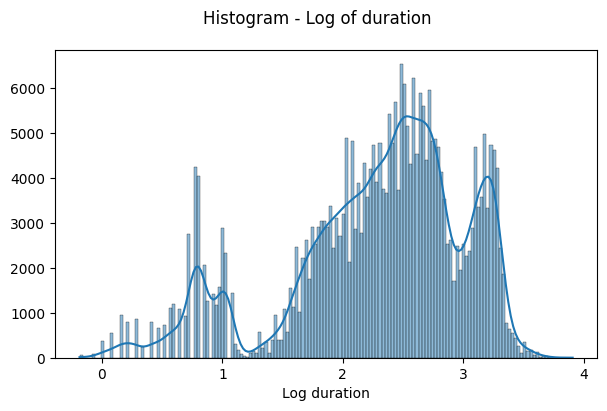

In [11]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.histplot(np.log(df['duration']), ax=ax, kde=True)
ax.set_ylabel('')
ax.set_xlabel('Log duration')
fig.suptitle('Histogram - Log of duration');

The gaps are again evident in the log of duration, but, we will do log-transformation during the model building as this distribution is more closer to empirical distribution.

### Histogram of target

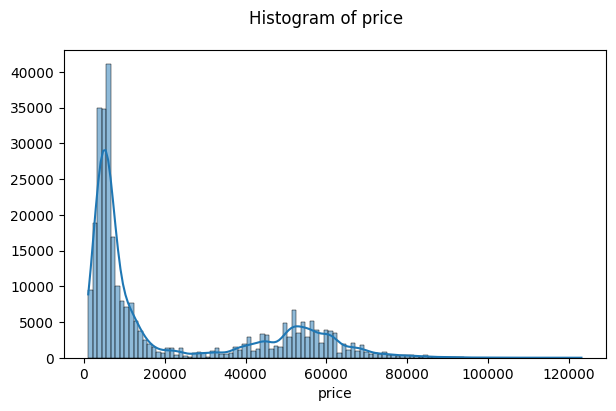

In [12]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.histplot(df, x='price', ax=ax, kde=True)
ax.set_ylabel('')
fig.suptitle('Histogram of price');

The price definitely follows a log-normal distribution. Log transformation should be done before training the linear models (linear regression, ridge) and the inverse (exponent) of the prediction should be the output of the model.

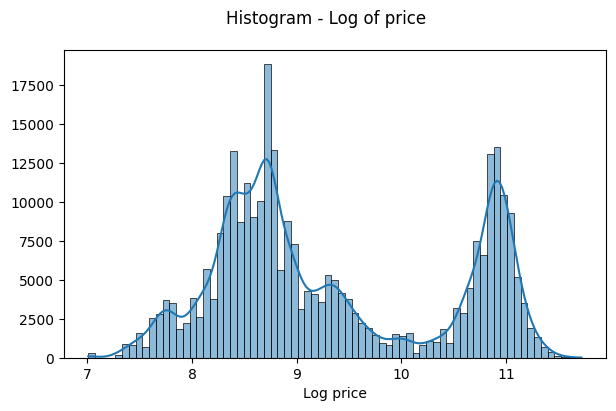

In [13]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.histplot(np.log(df['price']), ax=ax, kde=True)
ax.set_ylabel('')
ax.set_xlabel('Log price')
fig.suptitle('Histogram - Log of price');

The histogram has two peaks. Tree based models and ensembles can fit the data better than linear models.

### Boxplot of target

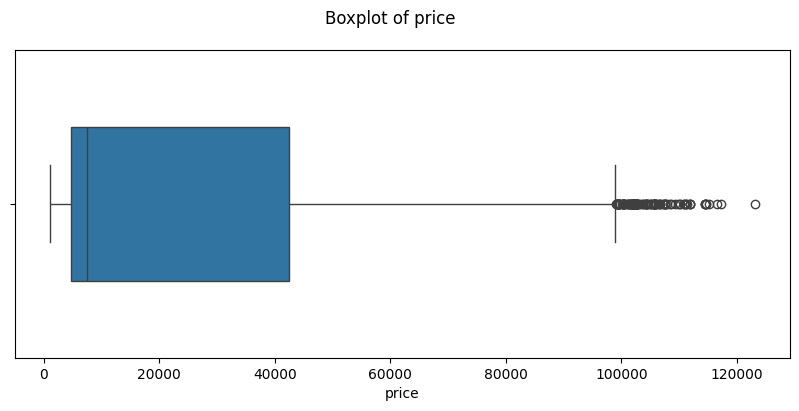

In [14]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(df, x='price', ax=ax, width=0.5)
ax.set_ylabel('')
ax.set_xlabel('price')
fig.suptitle('Boxplot of price');

From the boxplot, it is evident that, there are a large number of outliers. To minimize their influence, let's remove the datapoints, that are greater than 95th percentile and plot the boxplot again

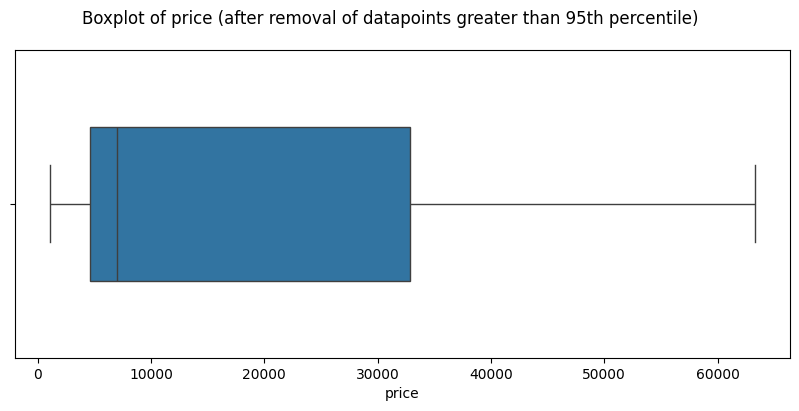

In [15]:
df_clean = df[df['price'] < df['price'].quantile(0.95)]

fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(df_clean, x='price', ax=ax, width=0.5)
ax.set_ylabel('')
ax.set_xlabel('price')
fig.suptitle('Boxplot of price (after removal of datapoints greater than 95th percentile)');

The `df_clean` does not have any outliers. Let's copy the new `df_clean` to the `df` variable.

In [16]:
df = df_clean.copy()

In [17]:
df

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955
...,...,...,...,...,...,...,...,...,...,...,...
300142,Air_India,AI-539,Chennai,Evening,one,Morning,Hyderabad,Business,16.00,49,51345
300143,Air_India,AI-440,Chennai,Early_Morning,one,Night,Hyderabad,Business,17.42,49,51345
300144,Air_India,AI-539,Chennai,Evening,one,Morning,Hyderabad,Business,18.92,49,51345
300145,Air_India,AI-430,Chennai,Morning,one,Morning,Hyderabad,Business,23.08,49,51345


## Bivariate analysis

### Scatter plot of numerical features with target

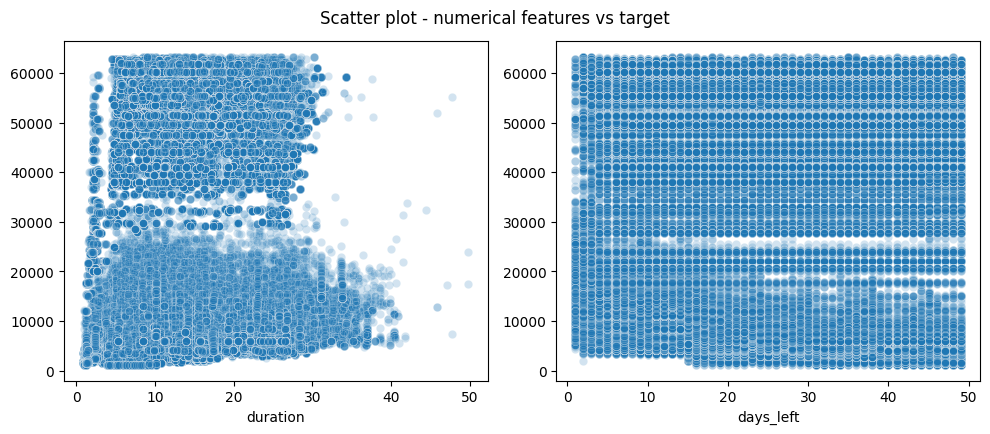

In [18]:
fig, ax = plt.subplots(nrows=len(numerical)//2+1, ncols=2, figsize=(10, len(numerical)*4))

for i, col in enumerate(numerical):
    ind = divmod(i, 2)
    sns.scatterplot(df, x=col, y=target, ax=ax[ind], alpha=0.2)
    ax[ind].set_ylabel('')

fig.delaxes(ax[len(numerical)//2, 1])
if len(numerical)%2 == 0:
    fig.delaxes(ax[len(numerical)//2, 0])

fig.suptitle('Scatter plot - numerical features vs target')
fig.tight_layout()

The `duration` feature shows a very low positive correlation with high heteroskedasticity, while the `days_left` shows no correlation. `days_left` is not a useful predictor and can be removed during model building.

### Boxplot of price based on different categorical features

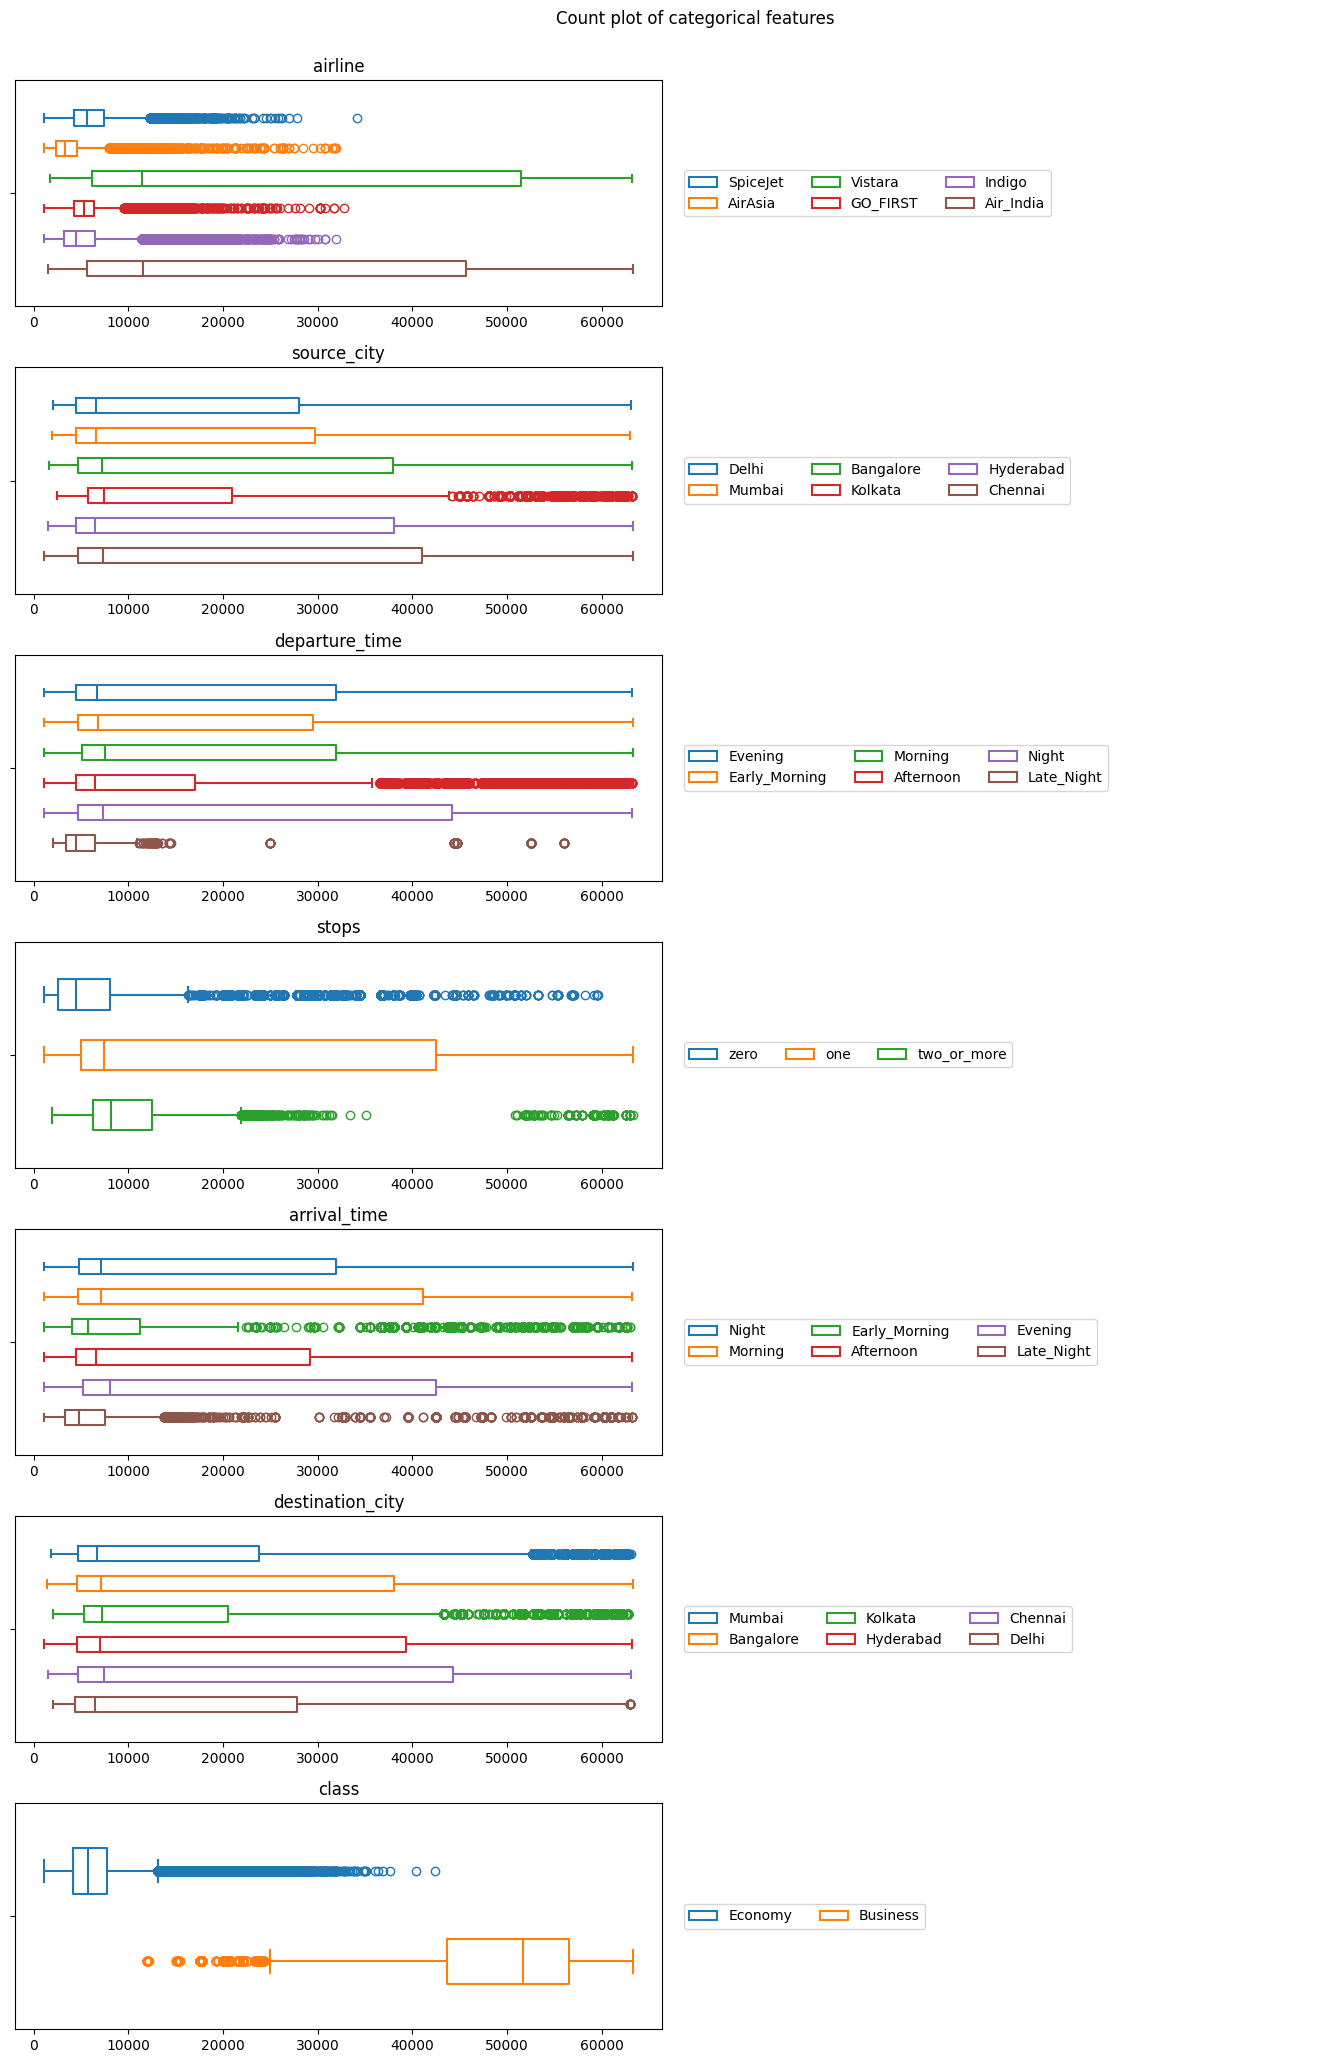

In [19]:
fig, ax = plt.subplots(nrows=len(categorical), ncols=2, figsize=(14, len(categorical)*3))

for i, col in enumerate(categorical):
    
    sns.boxplot(df, x=target, hue=col, gap=0.5, ax=ax[i, 0], fill=False)
    ax[i, 0].set_title(col)
    ax[i, 0].set_xlabel('')
    handles, labels = ax[i, 0].get_legend_handles_labels()
    ax[i, 0].legend().remove()  
    ax[i, 1].legend(handles, labels, loc='center left', ncols=3)
    ax[i, 1].axis('off') 

fig.suptitle('Count plot of categorical features')
plt.tight_layout(rect=[0,0,0.96,0.98])

From the boxplot, we can see the major predictor of `price` with clear seperation is the `class` variable. Airline shows moderate variations in the boxplots followed by number of stops, arrival and departure time, while the place of embark and debark shows very minimal variations in price.  

## Multivariate analysis
## Association plot

<Axes: >

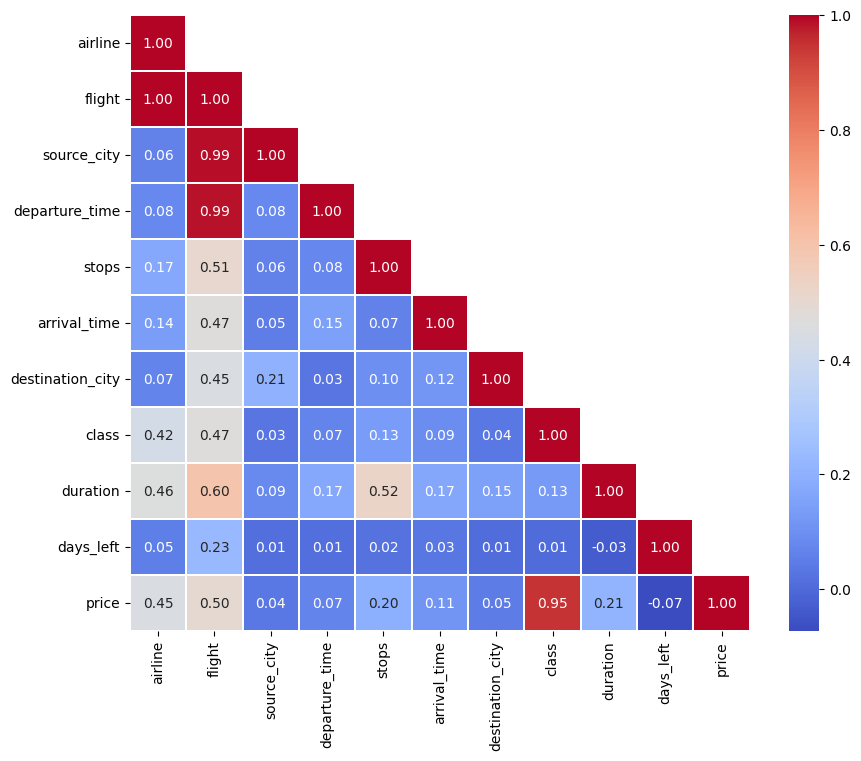

In [20]:
plt.subplots(figsize=(10,8))

corr = associations(df, compute_only=True)['corr']

sns.heatmap(corr, mask=np.triu(np.ones_like(corr), k=1), cmap='coolwarm', linewidths=0.2, annot=True, fmt='0.2f')

The `flight` column is completely correlated with `airline`, indicating high multi-collinearity. We can remove `flight` on training. Also, we can see, the strong predictors of the `price` are `class`, `airline`, `duration`, `stops`.

# Features and target setup

Before going to model building phase, we will remove the meaningless variables, split the data into training and testing set.

In [21]:
numerical = ['duration']
categorical_ohe = ['class', 'airline', 'departure_time', 'arrival_time', 'source_city', 'destination_city']
categorical_ordinal = ['stops']
target = 'price'

X = df[numerical + categorical_ohe + categorical_ordinal]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'X_train shape: {X_train.shape} \tX_test shape: {X_test.shape}')
print(f'y_train shape: {y_train.shape} \ty_test shape: {y_test.shape}')

X_train shape: (228108, 8) 	X_test shape: (57028, 8)
y_train shape: (228108,) 	y_test shape: (57028,)


# Model building
## Baseline model

The baseline model in our case is the one that predicts the mean of the target for all the datapoint. We will evaluate all the models comparing to the baseline in terms of **MSE**, **MAE** and **R<sup>2</sup>**

In [22]:
def metric(model, X, y):
    mae = mean_absolute_error(y, model.predict(X))
    mse = mean_squared_error(y, model.predict(X))
    r2 = r2_score(y, model.predict(X))
    print(f'Mean absolute Error: {round(mae, 4)}')
    print(f'Mean squared Error: {round(mse, 4)}')
    print(f'R2 score: {round(r2, 4)}')

In [23]:
dummy = DummyRegressor()
model_dummy = dummy.fit(X_train, y_train)

In [24]:
metric(model_dummy, X_test, y_test)

Mean absolute Error: 17006.5196
Mean squared Error: 400194791.3785
R2 score: -0.0001


The baseline has very large MAE and MSE, while the R<sup>2</sup> is 0.

## Pipeline

In [25]:
def get_transformer_pipe():
    numerical_pipe = Pipeline(
        [
            ('transform', FunctionTransformer(func=np.log, inverse_func=np.exp)),
            ('scaler', StandardScaler())
        ]
    )

    categorical_ordinal_pipe = Pipeline(
        [
            ('ordinal_encoder', OrdinalEncoder(categories=[['zero', 'one', 'two_or_more']]))
        ]
    )
    
    selector = ColumnTransformer(
        [
            ('numerical', numerical_pipe, numerical),
            ('categorical_nominal', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), categorical_ohe),
            ('categorical_ordinal', categorical_ordinal_pipe, categorical_ordinal)
        ]
    )
    
    pipe = Pipeline(
        [
            ('selector', selector)
        ]
    )

    return pipe

def get_predictor(predictor):
    pipe = get_transformer_pipe()
    pipe.steps.append(('predictor', predictor))
    return pipe

## Linear regression

The linear regression model works by fitting a hyperplane in the n-d space, that minimizes the least square error of the predicted and actual value.

The model assumes
$y=\beta^TX$
where, $\beta = \begin{bmatrix}\beta_0, \beta_1, \beta_2, ..., \beta_n \end{bmatrix}^T$ and $X = \begin{bmatrix}1, X_1, X_2, ... X_n \end{bmatrix}^T$. The closed-form solution of $\beta$ is given by $\beta = (X^TX)^{-1}X^Ty$

In [26]:
lr = LinearRegression()
model_lr = TransformedTargetRegressor(get_predictor(lr), func=np.log, inverse_func=np.exp)

model_lr.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('selector',
                                                      ColumnTransformer(transformers=[('numerical',
                                                                                       Pipeline(steps=[('transform',
                                                                                                        FunctionTransformer(func=<ufunc 'log'>,
                                                                                                                            inverse_func=<ufunc 'exp'>)),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['duration']),
                                                                                      ('categorical_nominal',
                                                                                       OneHotEncoder(drop='first',
                                                                                                     handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['class',
                                                                                        'airline',
                                                                                        'departure_time',
                                                                                        'arrival_time',
                                                                                        'source_city',
                                                                                        'destination_city']),
                                                                                      ('categorical_ordinal',
                                                                                       Pipeline(steps=[('ordinal_encoder',
                                                                                                        OrdinalEncoder(categories=[['zero',
                                                                                                                                    'one',
                                                                                                                                    'two_or_more']]))]),
                                                                                       ['stops'])])),
                                                     ('predictor',
                                                      LinearRegression())]))

In [27]:
metric(model_lr, X_test, y_test)

Mean absolute Error: 3431.2127
Mean squared Error: 25461389.9668
R2 score: 0.9364


### Statistical analysis

In [28]:
X_train_transformed = pd.DataFrame(get_transformer_pipe().fit_transform(X_train, y_train))
X_train_transformed.columns = np.concatenate([numerical, np.concatenate([y[1:] for y in df[categorical_ohe].apply(lambda x: x.unique()).values]), categorical_ordinal])
X_train_transformed.index = y_train.index
lr_ols = OLS(y_train, add_constant(X_train_transformed))
model_ols = lr_ols.fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                 9.737e+04
Date:                Fri, 07 Jun 2024   Prob (F-statistic):               0.00
Time:                        17:09:05   Log-Likelihood:            -2.2895e+06
No. Observations:              228108   AIC:                         4.579e+06
Df Residuals:                  228079   BIC:                         4.579e+06
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4.375e+04     95.195    459.549      0.000    4.36e+04    4.39e+04
duration       1389.1078     18.701     74.281      0.000    1352.455    1425.761
Business      -4.181e+04     28.825  -1450.351      0.000   -4.19e+04   -4.17e+04
AirAsia        1408.0808     57.789     24.366      0.000    1294.817    1521.345
Vistara        2025.7746     64.135     31.586      0.000    1900.072    2151.478
GO_FIRST       2652.8586     58.753     45.152      0.000    2537.703    2768.014
Indigo         2587.8906     83.356     31.046      0.000    2424.514    2751.267
Air_India      3367.8524     55.963     60.180      0.000    3258.166    3477.539
Early_Morning   549.7521     38.640     14.228      0.000     474.019     625.485
Morning         100.4536     39.265      2.558      0.011      23.495     177.412
Afternoon       955.5364    178.192      5.362      0.000     606.284    1304.789
Night           409.7085     37.928     10.802      0.000     335.371     484.046
Late_Night      383.3516     42.773      8.962      0.000     299.517     467.186
Morning       -1395.7044     61.459    -22.710      0.000   -1516.162   -1275.247
Early_Morning   689.7798     39.829     17.319      0.000     611.716     767.844
Afternoon       563.7829     64.242      8.776      0.000     437.870     689.696
Evening        -301.5553     41.924     -7.193      0.000    -383.725    -219.386
Late_Night      499.5711     39.004     12.808      0.000     423.124     576.019
Mumbai         -356.7726     43.441     -8.213      0.000    -441.916    -271.629
Bangalore     -1381.2032     39.365    -35.087      0.000   -1458.358   -1304.048
Kolkata       -1432.1053     42.923    -33.364      0.000   -1516.233   -1347.977
Hyderabad       819.5549     41.961     19.532      0.000     737.313     901.797
Chennai        -904.6109     39.300    -23.018      0.000    -981.638    -827.584
Bangalore      -254.5576     43.088     -5.908      0.000    -339.008    -170.107
Kolkata       -1325.5723     40.271    -32.916      0.000   -1404.503   -1246.642
Hyderabad     -1311.7327     42.484    -30.876      0.000   -1395.000   -1228.466
Chennai         679.2010     41.519     16.359      0.000     597.825     760.577
Delhi          -713.5716     39.841    -17.911      0.000    -791.658    -635.485
stops          3228.3401     42.510     75.942      0.000    3145.021    3311.659
==============================================================================
Omnibus:                    21553.668   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            69721.574
Skew:                          -0.483   Prob(JB):                         0.00
Kurtosis:                       5.530   Cond. No.                         28.5
================================================================

The p-values of the t-test in the table has a null hypothesis that there is no relationship between the predictor and the response variables. The null hypothesis must be rejected to indicate there is a relationship. From the statistical table above, we can infer that only the `AirAsia`, which is a one-hot encoded value of Airline does not reject the null hypothesis. The model also rejects the null hypothesis of the f-test, which indicates the overall model is a good fit to the data.

## Ridge regression

In [29]:
ridge = RidgeCV()
model_ridge = TransformedTargetRegressor(get_predictor(ridge), func=np.log, inverse_func=np.exp)

model_ridge.fit(X_train, y_train)

TransformedTargetRegressor(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>,
                           regressor=Pipeline(steps=[('selector',
                                                      ColumnTransformer(transformers=[('numerical',
                                                                                       Pipeline(steps=[('transform',
                                                                                                        FunctionTransformer(func=<ufunc 'log'>,
                                                                                                                            inverse_func=<ufunc 'exp'>)),
                                                                                                       ('scaler',
                                                                                                        StandardScaler())]),
                                                                                       ['duration']),
                                                                                      ('categorical_nominal',
                                                                                       OneHotEncoder(drop='first',
                                                                                                     handle_unknown='ignore',
                                                                                                     sparse_output=False),
                                                                                       ['class',
                                                                                        'airline',
                                                                                        'departure_time',
                                                                                        'arrival_time',
                                                                                        'source_city',
                                                                                        'destination_city']),
                                                                                      ('categorical_ordinal',
                                                                                       Pipeline(steps=[('ordinal_encoder',
                                                                                                        OrdinalEncoder(categories=[['zero',
                                                                                                                                    'one',
                                                                                                                                    'two_or_more']]))]),
                                                                                       ['stops'])])),
                                                     ('predictor', RidgeCV())]))

In [30]:
metric(model_ridge, X_test, y_test)

Mean absolute Error: 3431.2729
Mean squared Error: 25461986.1876
R2 score: 0.9364


The ridge regression, which is a linear model with regularization, which penalizes the contributions from the data points with high squared errors works only as well as the linear regression model.

## Decision tree regression

In [31]:
dt = DecisionTreeRegressor(random_state=42)
pipe_dt = get_predictor(dt)

params = {
    'predictor__max_depth': np.arange(5, 50, 5),
    'predictor__min_samples_split': np.arange(5, 50, 5),
    'predictor__min_samples_leaf': np.arange(5, 50, 5),
    'predictor__criterion': ['friedman_mse', 'squared_error', 'poisson', 'absolute_error'],
}


model_dt = RandomizedSearchCV(
    estimator=pipe_dt,
    n_iter=10,
    param_distributions=params,
    scoring='r2',
    random_state=42,
    cv=5,
    verbose=3
)

model_dt.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END predictor__criterion=squared_error, predictor__max_depth=10, predictor__min_samples_leaf=30, predictor__min_samples_split=30;, score=0.960 total time=   0.5s
[CV 2/5] END predictor__criterion=squared_error, predictor__max_depth=10, predictor__min_samples_leaf=30, predictor__min_samples_split=30;, score=0.960 total time=   0.5s
[CV 3/5] END predictor__criterion=squared_error, predictor__max_depth=10, predictor__min_samples_leaf=30, predictor__min_samples_split=30;, score=0.959 total time=   0.5s
[CV 4/5] END predictor__criterion=squared_error, predictor__max_depth=10, predictor__min_samples_leaf=30, predictor__min_samples_split=30;, score=0.960 total time=   0.5s
[CV 5/5] END predictor__criterion=squared_error, predictor__max_depth=10, predictor__min_samples_leaf=30, predictor__min_samples_split=30;, score=0.959 total time=   0.5s
[CV 1/5] END predictor__criterion=squared_error, predictor__max_depth=35, predictor_

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('selector',
                                              ColumnTransformer(transformers=[('numerical',
                                                                               Pipeline(steps=[('transform',
                                                                                                FunctionTransformer(func=<ufunc 'log'>,
                                                                                                                    inverse_func=<ufunc 'exp'>)),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['duration']),
                                                                              ('categorical_nominal',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['class',...
                                              DecisionTreeRegressor(random_state=42))]),
                   param_distributions={'predictor__criterion': ['friedman_mse',
                                                                 'squared_error',
                                                                 'poisson',
                                                                 'absolute_error'],
                                        'predictor__max_depth': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45]),
                                        'predictor__min_samples_leaf': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45]),
                                        'predictor__min_samples_split': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45])},
                   random_state=42, scoring='r2', verbose=3)

In [32]:
metric(model_dt, X_test, y_test)

Mean absolute Error: 1880.8611
Mean squared Error: 8468226.5525
R2 score: 0.9788


The decison tree regressor with hyperparameter tuning has produced an R<sup>2</sup> score of 0.9579, which is better than linear model.

### Tree visualization

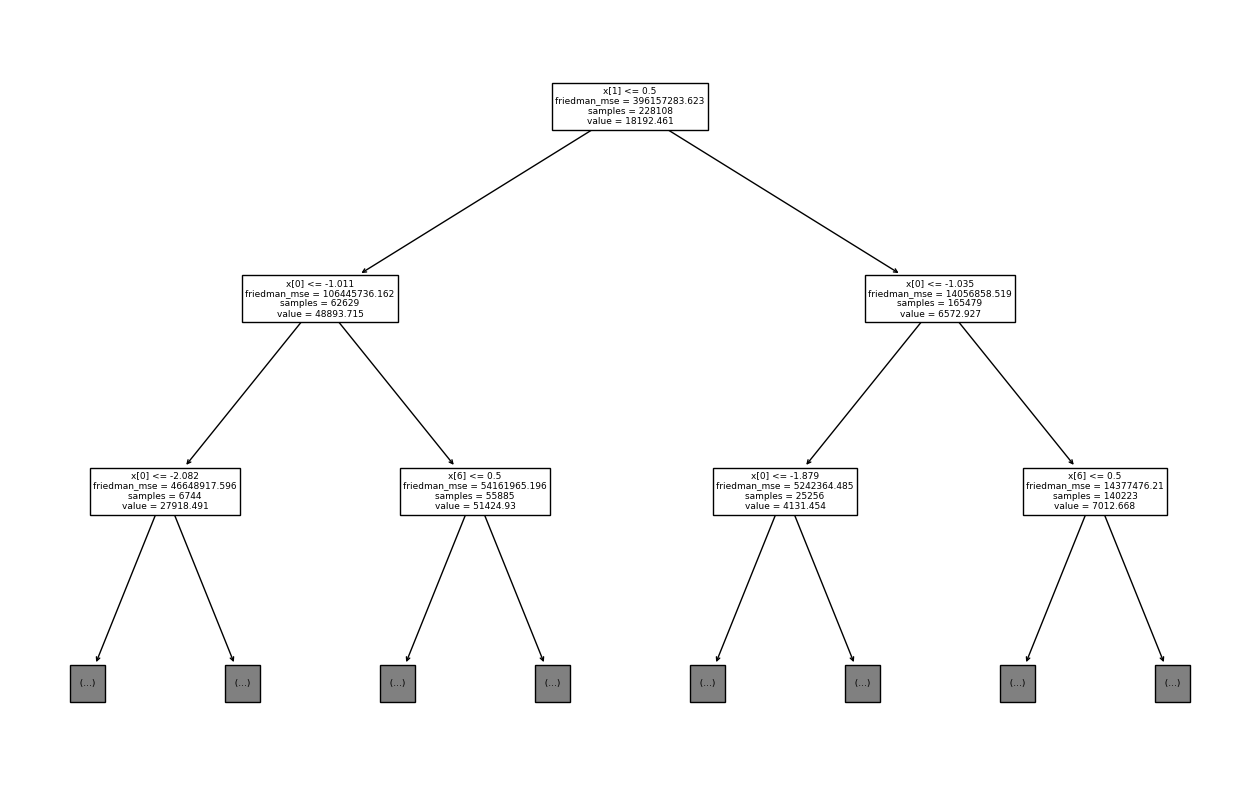

In [33]:
plt.subplots(figsize=(16,10))

plot_tree(model_dt.best_estimator_.named_steps['predictor'], max_depth=2);

The above plot shows the decision tree upto depth of 3. It show how the decision tree allocates the datapoints to various bins based on the criteria.

## Random forest regression

Random forest regressor is a bagging ensemble that fits several decision tree models and use the average of those models to predict the final value.

In [34]:
rf = RandomForestRegressor(n_estimators=20, random_state=42)
pipe_rf = get_predictor(rf)

params = {
    'predictor__max_depth': np.arange(5, 50, 5),
    'predictor__min_samples_split': np.arange(5, 50, 5),
    'predictor__min_samples_leaf': np.arange(5, 50, 5),
    'predictor__criterion': ['friedman_mse', 'squared_error', 'poisson', 'absolute_error'],
}


model_rf = RandomizedSearchCV(
    estimator=pipe_rf,
    n_iter=10,
    param_distributions=params,
    scoring='r2',
    random_state=42,
    cv=5,
    verbose=3
)

model_rf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END predictor__criterion=squared_error, predictor__max_depth=10, predictor__min_samples_leaf=30, predictor__min_samples_split=30;, score=0.961 total time=   3.6s
[CV 2/5] END predictor__criterion=squared_error, predictor__max_depth=10, predictor__min_samples_leaf=30, predictor__min_samples_split=30;, score=0.961 total time=   3.3s
[CV 3/5] END predictor__criterion=squared_error, predictor__max_depth=10, predictor__min_samples_leaf=30, predictor__min_samples_split=30;, score=0.961 total time=   3.3s
[CV 4/5] END predictor__criterion=squared_error, predictor__max_depth=10, predictor__min_samples_leaf=30, predictor__min_samples_split=30;, score=0.962 total time=   3.3s
[CV 5/5] END predictor__criterion=squared_error, predictor__max_depth=10, predictor__min_samples_leaf=30, predictor__min_samples_split=30;, score=0.961 total time=   3.3s
[CV 1/5] END predictor__criterion=squared_error, predictor__max_depth=35, predictor_

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('selector',
                                              ColumnTransformer(transformers=[('numerical',
                                                                               Pipeline(steps=[('transform',
                                                                                                FunctionTransformer(func=<ufunc 'log'>,
                                                                                                                    inverse_func=<ufunc 'exp'>)),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['duration']),
                                                                              ('categorical_nominal',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['class',...
                                                                    random_state=42))]),
                   param_distributions={'predictor__criterion': ['friedman_mse',
                                                                 'squared_error',
                                                                 'poisson',
                                                                 'absolute_error'],
                                        'predictor__max_depth': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45]),
                                        'predictor__min_samples_leaf': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45]),
                                        'predictor__min_samples_split': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45])},
                   random_state=42, scoring='r2', verbose=3)

In [35]:
metric(model_dt, X_test, y_test)

Mean absolute Error: 1880.8611
Mean squared Error: 8468226.5525
R2 score: 0.9788


The metrics of random forest model is exactly the same as the decision tree model. Increasing the search space and the number of iterations in the random search might improve the metrics, but it comes at the cost of increased training time.

# Discussion and conclusion

In this study, we did the exploratory data analysis, visualized the distributions, built model pipelines to transform the raw data and finally built few regressors, namely linear regression, ridge, decision tree and random forest. All the models had shown excellent performance with R<sup>2</sup> scores greater than 93%. As expected, due to the presence of large number of categorical features and the target not being normally distributed, the tree based regressors (decision tree / random forest) have shown superior performance with R<sup>2</sup> close to 98%. Future work would involve building more complex models such as SVM or ANN, but given the high R<sup>2</sup> score of 98%, it can be difficult for other models to show better performances, as the errors may only be due to the noise in the dataset. Even though outliers were removed considering the prices as a whole, from the boxplot of prices plotted based on various categories, it is evident that there are significant number of outliers on each categories. Thus, the future work would involve processing the outliers individually considering all the categorical variables. This can ensure a much better estimator than the ones built in this study.